# Lab03 Report 

## ResNet18 and SEResNet18

In this section of Lab03, ResNet model was implemented on the CIFAR-10 dataset. With the same data set, 2 versions of ResNet were employed namely,

- ResNet18
- ResNet18 with Squeeze and Excitation (SEResNet18)

Firstly, the datasets are transformed to 256x256 scaling and 224x224 cropping for CIFAR as standardized for ImageNet and modified the implementation to use the same convolutions (e.g., initial 7x7). After that,some layers are employed since the given architechture of ResNet was not the same as what can be found on the original paper. The added layers are in the following.
- The input image size
- The modification of the first convolutional layer
- The addition of a maxpool
- The padding
- The kernal size

The two versions were impleneted with the exact same optimizer as well as the loss functions and they are as follows:
- criterion = nn.CrossEntropyLoss()
- optimizer = optim.Adam(model.parameters(), lr=0.01)


The number of trainable parameters of each model are as follows:
- ResNet18 has 11,181,642 trainable parameters
- SEResNet18 has 11,268,682 trainable parameters


The models were both trained for 25 epochs with the batch size of 16 and their performace at the 25th epoch are:
- ResNet18: Train acc = 93.44% , Val acc = 83.98% , Test acc = 85.08% 
- SEResNet18: Train acc = 96.44% , Val acc = 82.15% , Test acc = 83.05% 



#### Importing Libraries

In [5]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import numpy as np
from torchvision.transforms.transforms import RandomCrop

### 1.Prepare Dataset

In the below cell, the datasets are transformed to 256x256 scaling and 224x224 cropping for CIFAR as standardized for ImageNet.

In [15]:
## Resize to 256
### AUGMENT for train
train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

## Resize to 224
### No AUGMENT for test
eval_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=eval_preprocess)


# Prepare the data loaders
BATCH_SIZE=16
NUM_WORKERS=2

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

Files already downloaded and verified
Files already downloaded and verified


### 2.Define Model

In this following Resnet class architecture, the implementation to use 7 for kernel size, 2 for stride and 3 for padding are implemented. 
The class BottleneckBlock, class BasicBlock and the function ResNet18 are changed nothing so I skip them in this report.

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


### 3.Define for function evaluation 

The class evaluate from the below cell stands for the testing.

In [12]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
                
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues


### 4. Results

#### 4.1 Resnet

For the results, I created new files to save the train losses, val losses and time taken for each 25 epoches and the .txt file is shown in below.

In [42]:
resnet18_result = open("output.txt", "r")
print(resnet18_result.read())

====================== New Run =======================
Epoch 0/24
----------
train Loss: 1.8897 Acc: 0.2865
Epoch time taken: 654.0159502029419
val Loss: 1.6248 Acc: 0.4020
Epoch time taken: 704.2495431900024
Epoch 1/24
----------
train Loss: 1.3662 Acc: 0.5061
Epoch time taken: 656.3922257423401
val Loss: 1.1748 Acc: 0.5833
Epoch time taken: 706.6556115150452
Epoch 2/24
----------
train Loss: 1.0765 Acc: 0.6178
Epoch time taken: 660.3247539997101
val Loss: 0.9954 Acc: 0.6508
Epoch time taken: 712.6144573688507
Epoch 3/24
----------
train Loss: 0.9195 Acc: 0.6766
Epoch time taken: 671.927163362503
val Loss: 0.8655 Acc: 0.6966
Epoch time taken: 730.9818484783173
Epoch 4/24
----------
train Loss: 0.8058 Acc: 0.7195
Epoch time taken: 698.9768545627594
val Loss: 0.7838 Acc: 0.7320
Epoch time taken: 749.3615391254425
Epoch 5/24
----------
train Loss: 0.7232 Acc: 0.7458
Epoch time taken: 652.7142059803009
val Loss: 0.6877 Acc: 0.7610
Epoch time taken: 702.9611570835114
Epoch 6/24
----------


#### 4.2 SEResnet

In [14]:
SEresnet18_result = open("outputSE.txt", "r")
print(SEresnet18_result.read())

====================== New Run =======================
Epoch 0/24
----------
train Loss: 1.7253 Acc: 0.3661
Epoch time taken: 181.560795545578
val Loss: 1.5392 Acc: 0.4544
Epoch time taken: 202.71159482002258
Epoch 1/24
----------
train Loss: 1.2321 Acc: 0.5574
Epoch time taken: 183.8565845489502
val Loss: 1.0812 Acc: 0.6207
Epoch time taken: 205.04378199577332
Epoch 2/24
----------
train Loss: 0.9731 Acc: 0.6599
Epoch time taken: 183.80808281898499
val Loss: 0.8443 Acc: 0.7060
Epoch time taken: 204.99090814590454
Epoch 3/24
----------
train Loss: 0.7826 Acc: 0.7259
Epoch time taken: 183.35695719718933
val Loss: 0.7339 Acc: 0.7484
Epoch time taken: 204.3735625743866
Epoch 4/24
----------
train Loss: 0.6607 Acc: 0.7679
Epoch time taken: 182.95550084114075
val Loss: 0.6557 Acc: 0.7761
Epoch time taken: 204.1663293838501
Epoch 5/24
----------
train Loss: 0.5753 Acc: 0.7980
Epoch time taken: 182.6628623008728
val Loss: 0.6570 Acc: 0.7790
Epoch time taken: 203.77781987190247
Epoch 6/24
----

### 5. Check avilability of the GPU

In [31]:
from chosen_gpu import get_free_gpu

device = torch.device(get_free_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

### 6. Evaluation

In [72]:
from resnet import ResNet18
from SEbasicblock import ResSENet18

model_resnet = ResNet18()
model_SEresnet = ResSENet18()

model = model_resnet.to(device)
model_SE = model_SEresnet.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


model_resnet.load_state_dict(torch.load('resnet18_bestsofar.pth', 
                                        map_location=torch.device('cpu')))
model_SEresnet.load_state_dict(torch.load('SEresnet18_bestsofar.pth', 
                                          map_location=torch.device('cpu')))



# model_resnet = torch.load('resnet18_bestsofar.pth', map_location=torch.device('cpu'))
# model_SEresnet = torch.load('SEresnet18_bestsofar.pth', map_location=torch.device('cpu'))


resnet_test_loss,resnet_test_acc,
resnet_test_pred_label,resnet_test_true_label=evaluate(model_resnet,
                                                       test_dataloader, 
                                                       criterion)
SEresnet_test_loss, SEresnet_test_acc,
SEresnet_test_pred_label,SEresnet_test_true_label=evaluate(model_SEresnet,
                                                           test_dataloader,
                                                           criterion)
print('...................ResNet18....................', 
      file = open("test_resnet_seresnet.txt", "a"))
print(f'Test Loss: {resnet_test_loss:.3f} | Test Acc: {resnet_test_acc:.2f}%', 
      file = open("test_resnet_seresnet.txt", "a"))
print('...................SEResNet18 ...................', 
      file = open("test_resnet_seresnet.txt", "a"))
print(f'Test Loss: {SEresnet_test_loss:.3f} | Test Acc: {SEresnet_test_acc:.2f}%', 
      file = open("test_resnet_seresnet.txt", "a"))


The following is the test and loss result of the resnet and SEresnet.

In [54]:
test_result = open("test_resnet_seresnet.txt", "r")
print(test_result.read())

...................ResNet18....................
Test Loss: 0.653 | Test Acc: 85.08%
...................SEResNet18 ...................
Test Loss: 0.703| Test Acc: 83.05%



### 7. Plotting

In [69]:
import torch
import matplotlib.pyplot as plt

resnet_loss = torch.load('reset-18-cifar-10-loss-acc.pth', 
                         map_location=torch.device('cpu'))
seresnet_loss = torch.load('se-reset-18-cifar-10-loss-acc.pth', 
                           map_location=torch.device('cpu'))

resnet_val_acc = torch.load('reset-18-cifar-10-val-acc.pth', 
                            map_location=torch.device('cpu'))
seresnet_val_acc = torch.load('reset-18-cifar-10-loss-acc.pth', 
                              map_location=torch.device('cpu'))


plt.plot(resnet_loss, label = 'ResNet18')
plt.plot(seresnet_loss, label = 'ResSENet18')
plt.title('Training loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss-cifar-10.png', bbox_inches = 'tight')


plt.plot(resnet_val_acc, label = 'ResNet18')
plt.plot(seresnet_val_acc, label = 'ResSENet18')
plt.title('Validation accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.savefig('acc-cifar-10.png', bbox_inches = 'tight')


# Chihuahua or Muffin

In this section of Lab03, taken the trained SE_ResNet model from the previous section, the model was fine-tuned by adjusting the hyper-paremeters during the 8-fold cross validation.

Since SE_ResNet was initially trained for a 10-class classification problem, The last layer of the output must be modified. In our case, the last layer was changed from 10 to 2.

In [ ]:
def ResSENet18(num_classes = 2):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

The 8 variations (8-fold cross validation) were impleneted with Adam optimizer and crossentropy loss functions and they are as follows:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam() which starts lr = 0.05 and increases by 0.05 every model.

The model was trained for 25 epochs with the batch size of 4 and their performace at the 25th epoch are:

- With optimizer0: Avg acc = 0.9275000000000001
- With optimizer1: Avg acc = 0.915
- With optimizer2: Avg acc = 0.835
- With optimizer3: Avg acc = 0.8200000000000001
- With optimizer4: Avg acc = 0.7725
- With optimizer5: Avg acc = 0.83
- With optimizer6: Avg acc = 0.8049999999999999
- With optimizer7: Avg acc = 0.78

As for the evalution, optimizer2 was chosen due to its high accuracy as well as relatively less time taken to train which results in 92.75%.

### 1. Import the dataset

In [39]:
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import TensorDataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

dataset = dset.ImageFolder('/root/Lab03/chi_muf',
                       transform=transforms.Compose([
                           transforms.Resize(256),
                           transforms.CenterCrop(224),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

### 2.Define Train function

In [67]:
def train_model(model, dataloaders, criterion, 
                optimizer, num_epochs=25, 
                weights_name='weight_save', 
                is_inception=False):
    print('====================== New Run =======================',
          file=open(f"{weights_name}.txt", "a"))

    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), 
              file=open(f"{weights_name}.txt", "a"))
        print('-' * 10, file=open(f"{weights_name}.txt", "a"))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)

                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), 
                  file=open(f"{weights_name}.txt", "a"))
            print(f"Epoch time taken: {elapsed_epoch}", 
                  file=open(f"{weights_name}.txt", "a"))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, 
                                                        time_elapsed % 60), 
          file=open(f"{weights_name}.txt", "a"))
    print('Best val Acc: {:4f}'.format(best_acc), 
          file=open(f"{weights_name}.txt", "a"))

    return  val_acc_history, loss_acc_history

### 3. Perform 8-Fold Cross Validation

In [74]:
folds = 8
skf = StratifiedKFold(n_splits=folds, shuffle=True)


from modules import ResSENet18
models = []
def make_model(ResSENet18):
    model = ResSENet18()
    model.load_state_dict(torch.load('SEresnet18_bestsofar.pth'))
    model.linear = nn.Linear(512,2)
    model.eval()
    return model

n_models = 8

for i in np.arange(n_models):
    fig,ax = plt.subplots(1,2,sharex=True,figsize=(20,5))
    model_acc = 0
    for fold, (train_index, val_index) in enumerate(skf.split(dataset, 
                                                              dataset.targets)):
        print('********************* Fold {}/{} ******************** '.format(fold, 8 - 1), 
              file=open(f"SE_muff_chi_model{i}.txt", "a"))
        batch_size = 4
        train = torch.utils.data.Subset(dataset, train_index)
        val = torch.utils.data.Subset(dataset, val_index)
        
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                                   shuffle=True, num_workers=0, 
                                                   pin_memory=False)
        val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                                 shuffle=True, num_workers=0, 
                                                 pin_memory=False)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = make_model(ResSENet18)
        model.to(device)
        dataloaders = {'train': train_loader, 'val': val_loader}
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer =  optim.Adam(model.parameters(), lr = 0.005 + 0.005*i)

        val_acc_history, loss_acc_history = train_model(model, dataloaders, 
                                                        criterion, optimizer, 
                                                        25, f'SE_muff_chi_model{i}')
        #print(len(val_acc_history))
        #print(sum(val_acc_history))         
        model_acc = model_acc + sum(val_acc_history)/len(val_acc_history)

    plt.show()
    print(f'Average accuracy of model{i}: {model_acc/8}')

After the implementaion 8-fold cross-validation 8 times to train 8 models, the average accuracy are save in .txt file which is shown in the below cell.

In [41]:
chi_muf_acc = open("muf_chi_Average_acc.txt", "r")
print(chi_muf_acc.read())

Average accuracy of model0: 0.9275000000000001
Average accuracy of model1: 0.915
Average accuracy of model2: 0.835
Average accuracy of model3: 0.8200000000000001
Average accuracy of model4: 0.7725
Average accuracy of model5: 0.83
Average accuracy of model6: 0.8049999999999999
Average accuracy of model7: 0.78



The below cell shown the implementation of 8-fold cross-validation 8 times to train 8 models to find the best hyperparameters.(e.g.,optimizer0 which has the highest average accuracy).

In [50]:
optimizer_0= open("SE_muff_chi_model0.txt", "r")
print(optimizer_0.read())

********************* Fold 0/7 ******************** 
====================== New Run =======================
Epoch 0/24
----------
train Loss: 0.6779 Acc: 0.6429
Epoch time taken: 0.34758782386779785
val Loss: 0.6522 Acc: 0.5000
Epoch time taken: 0.36956000328063965
Epoch 1/24
----------
train Loss: 0.6347 Acc: 0.5714
Epoch time taken: 0.31200361251831055
val Loss: 0.6098 Acc: 1.0000
Epoch time taken: 0.3371620178222656
Epoch 2/24
----------
train Loss: 0.6120 Acc: 0.8571
Epoch time taken: 0.31691431999206543
val Loss: 0.5787 Acc: 1.0000
Epoch time taken: 0.3443460464477539
Epoch 3/24
----------
train Loss: 0.5721 Acc: 0.9286
Epoch time taken: 0.31780052185058594
val Loss: 0.5265 Acc: 1.0000
Epoch time taken: 0.3435957431793213
Epoch 4/24
----------
train Loss: 0.5122 Acc: 0.9286
Epoch time taken: 0.32233309745788574
val Loss: 0.4719 Acc: 1.0000
Epoch time taken: 0.3478553295135498
Epoch 5/24
----------
train Loss: 0.4490 Acc: 1.0000
Epoch time taken: 0.3196854591369629
val Loss: 0.4295

### 4. Train with Optimizer2

I trained with Optimizer2 was chosen due to its highest in average accuracy

Optimizer2 = optim.Adam(model.parameters(), lr = 0.015)

After training the test accuracy is 83.75%


### 5. Evaluation

In [76]:
dataset_test = dset.ImageFolder('/root/Lab03/chi_muff_test',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(dataset_test,
                                              batch_size = 16,shuffle = True)



model_test = ResSENet18()
model_test.linear = nn.Linear(512,2)
model_test.eval()
model_test.to(device)
model_test.load_state_dict(torch.load(f'Train_SE_muff_chi_model.pth'))
criterion = nn.CrossEntropyLoss()
test_loss,test_acc,test_pred_label,test_true_label=evaluate(model_test, 
                                                            test_dataloader, 
                                                            criterion)

print('...................Result....................', 
      file = open("test_chi_muff.txt", "a"))
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%',
      file = open("test_chi_muff.txt", "a") )

In [63]:
chi_muf_result= open("test_chi_muff.txt", "r")
print(chi_muf_result.read())

...................Result....................
Test Loss: 0.649 | Test Acc: 83.75%



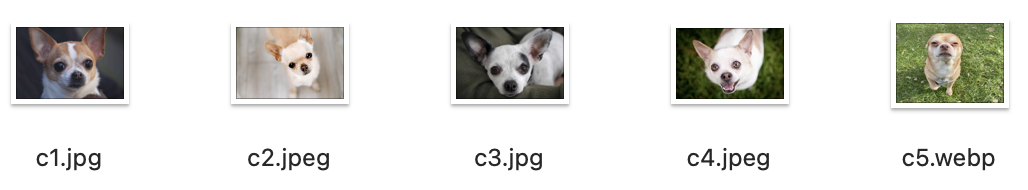

In [3]:
from IPython.display import display
from PIL import Image
display(Image.open("chi_test.png"))

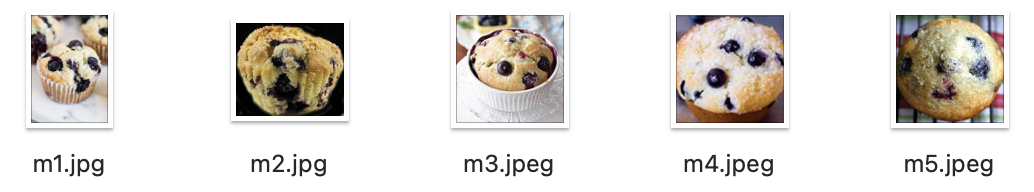

In [5]:
display(Image.open("muf_test.png"))

### 6. Conclusion

Since the test accuracy for chihuahua_or_muffun is 83.75% and test loss is 0.649, it seems quite good. The transfer learning in this lab was employed increaseing the size of training and validation data, modifying the model artchitecture to output 2 classes, some data augmentation or exploring more hyperparameters of the optimizer.

Moreover, I learned about the components of oridinary ResNet and Squeeze and Excite networks and more about implementing k-fold and cross-validation to find the best hyperparameters.

### Evidance of my Docker container running on the GPU server and get VSCode 

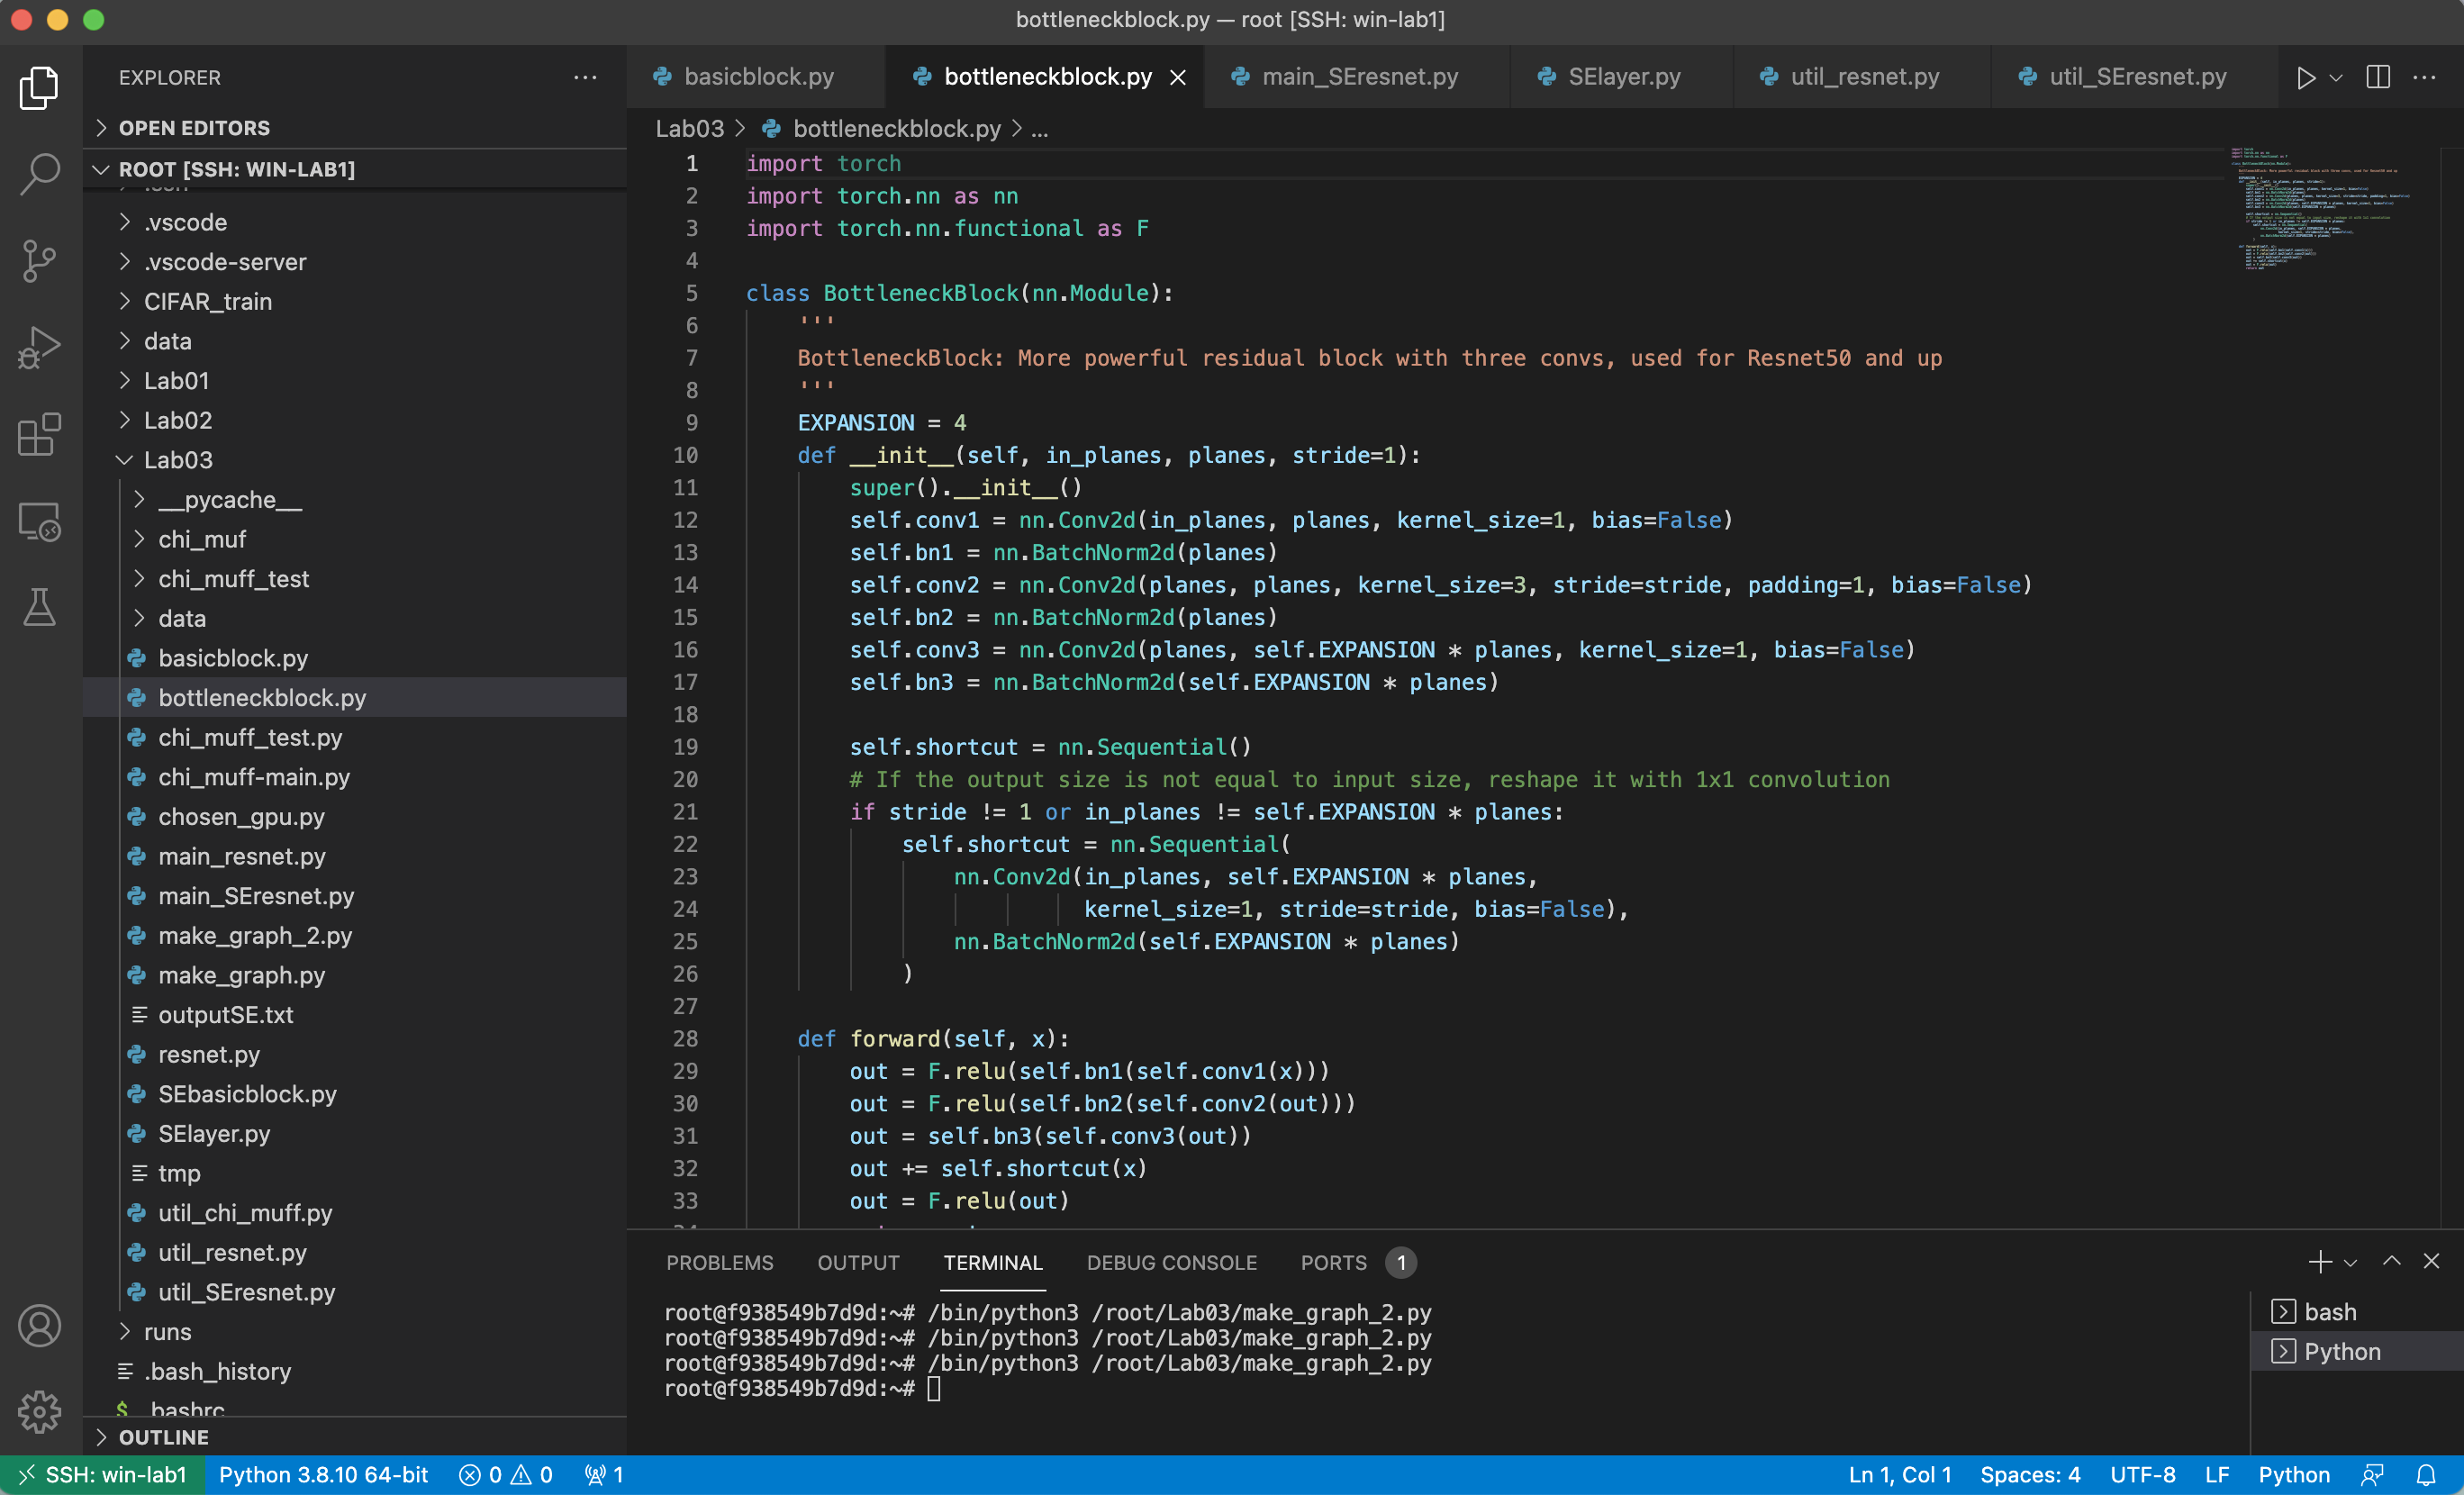

In [3]:
from IPython.display import display
from PIL import Image
display(Image.open("screenshot.png"))